In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

import pickle

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from sklearn.metrics import confusion_matrix

In [30]:
heart_data = "../data/clean/resampled_data.csv"
heart_df = pd.read_csv(heart_data)
heart_df = heart_df.drop(columns=['Unnamed: 0'], axis=1)

In [31]:
# Performing train split 

target = heart_df['HeartDiseaseorAttack']
features = heart_df.drop('HeartDiseaseorAttack', axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

In [32]:
#Normalise all columns to be 0-1
normalizer = MinMaxScaler()
normalizer.fit(x_train)

x_train_norm = normalizer.transform(x_train)
x_test_norm = normalizer.transform(x_test)

x_train_norm_df = pd.DataFrame(x_train_norm, columns=x_train.columns, index=x_train.index )
x_test_norm_df = pd.DataFrame(x_test_norm, columns=x_test.columns, index=x_test.index)

In [33]:
tree_model = DecisionTreeClassifier(max_depth=10)

In [34]:
tree_model.fit(x_train_norm_df, y_train)

DecisionTreeClassifier(max_depth=10)

In [38]:
y_pred_test_dt = tree_model.predict(x_test_norm_df)

In [39]:
# Relative importance
tree_importance = {feature : importance for feature, importance in zip(x_train_norm_df.columns, tree_model.feature_importances_)}
tree_importance

{'HighBP': 0.30708783925764166,
 'HighChol': 0.04925925423847659,
 'CholCheck': 0.0021880654062041787,
 'BMI': 0.03556682104388602,
 'Smoker': 0.012548943898164466,
 'Stroke': 0.03935509348382054,
 'Diabetes': 0.01161079891425579,
 'PhysActivity': 0.004989413466074159,
 'Fruits': 0.0016430257103084215,
 'Veggies': 0.002714781529392065,
 'HvyAlcoholConsump': 0.003010976393162889,
 'AnyHealthcare': 0.0021570467590139725,
 'NoDocbcCost': 0.0016323962883708653,
 'GenHlth': 0.18730712652584147,
 'MentHlth': 0.012057839549320886,
 'PhysHlth': 0.015986983299463544,
 'DiffWalk': 0.01638723470558765,
 'Sex': 0.04740765496252632,
 'Age': 0.2193290317926483,
 'Education': 0.009518071621457722,
 'Income': 0.018241601154382666}

In [40]:
from sklearn.tree import export_text

tree_viz = export_text(tree_model, feature_names=list(x_train_norm_df.columns))
print(tree_viz)

|--- HighBP <= 0.50
|   |--- Age <= 0.62
|   |   |--- GenHlth <= 0.62
|   |   |   |--- Stroke <= 0.50
|   |   |   |   |--- GenHlth <= 0.38
|   |   |   |   |   |--- HighChol <= 0.50
|   |   |   |   |   |   |--- Income <= 0.50
|   |   |   |   |   |   |   |--- Age <= 0.29
|   |   |   |   |   |   |   |   |--- PhysHlth <= 0.05
|   |   |   |   |   |   |   |   |   |--- Sex <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |--- Sex >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- PhysHlth >  0.05
|   |   |   |   |   |   |   |   |   |--- NoDocbcCost <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |--- NoDocbcCost >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- Age >  0.29
|   |   |   |   |   |   |   |   |--- MentHlth <= 0.87
|   |   |   |   |   |   |   |   |   |--- BMI <= 0.06
|   |   |   |   | 

### Accuracy of the decision tree:

In [41]:
accuracy = accuracy_score(y_test, y_pred_test_dt)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.76


### Confusion matrix figure:

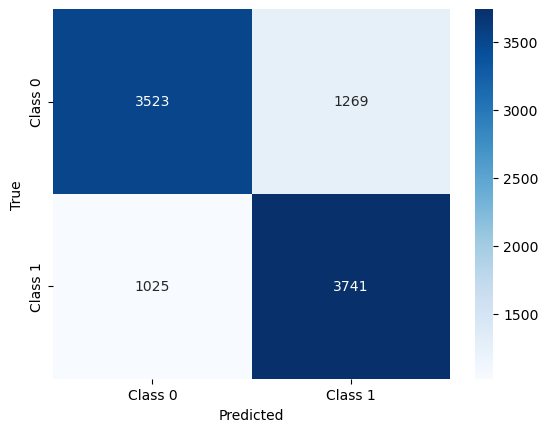

In [42]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test_dt)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification report:

In [43]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_test_dt)
print(f'Classification Report:\n{report}')

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75      4792
         1.0       0.75      0.78      0.77      4766

    accuracy                           0.76      9558
   macro avg       0.76      0.76      0.76      9558
weighted avg       0.76      0.76      0.76      9558



#### 1) Precision: The proportion of positive predictions that were actually correct (i.e., TP / (TP + FP)).
#### 2) Recall: The proportion of actual positive cases that were correctly identified (i.e., TP / (TP + FN)).
#### 3) F1-Score: The harmonic mean of precision and recall, useful when dealing with imbalanced classes.
#### 4) Support: The number of true instances for each class in the dataset.

### Cross validation:

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(tree_model, x_train_norm_df, y_train, cv=5)  

# Print the cross-validation scores and their mean
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {cv_scores.mean():.2f}')

Cross-validation scores: [0.74888831 0.74993461 0.75215799 0.75618051 0.76088947]
Mean CV score: 0.75


### Receiver Operating Characteristic Area Under the Curve:

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve

auc_dt = roc_auc_score(y_test, tree_model.predict_proba(x_test_norm_df)[:, 1])

print(f'AUC (Decision Tree): {auc_dt}')

AUC (Decision Tree): 0.8243590301572701
